In [12]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import os
import nltk
import string
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from scipy.stats import pearsonr
nltk.download('punkt')
nltk.download('stopwords')
import geopandas as gpd

df = pd.read_csv('/Users/ryanwang/Documents/GitHub/MAST30034_Python/project-2-group-real-estate-industry-project-10/data/landing/rent_data.csv')

[nltk_data] Downloading package punkt to /Users/ryanwang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ryanwang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:

# find duplicate data
duplicate_rows = df[df.duplicated()]

# find whether they have duplicate data
if duplicate_rows.shape[0] > 0:
    print(f"Found {duplicate_rows.shape[0]} duplicate rows:")
    print(duplicate_rows)
else:
    print("No duplicate rows found.")

# delete duplicate data
df_no_duplicates = df.drop_duplicates()
df1 = df_no_duplicates


Found 38 duplicate rows:
                                            price  bathrooms  bedrooms  \
220                                       $850.00          0         2   
460                                       $530.00          0         1   
480                                 $500 per week          0         1   
569              $950 **INSPECTION UPON REQUEST**          0         2   
601              $850 **INSPECTION UPON REQUEST**          0         2   
640               $850 per week & Fully Furnished          0         2   
644                                 $830 Per Week          0         2   
713      $660 **GREAT CONDITION, PRIME LOCATION**          0         2   
780    $600 **GREAT CONDITION, CARPARK INCLUDED**          0         1   
862                                           $60          0         0   
863                                          $261          0         0   
998                                          $550          0         1   
999          

In [15]:
# check whether every column has missing value
for column in df_no_duplicates.columns:
    if df_no_duplicates[column].isnull().any():
        print(f"Column '{column}' has missing values!")
    else:
        print(f"Column '{column}' does not have any missing values.")
# delete missing value
cleaned_data = df1.dropna()

Column 'price' does not have any missing values.
Column 'bathrooms' does not have any missing values.
Column 'bedrooms' does not have any missing values.
Column 'parking' does not have any missing values.
Column 'type' does not have any missing values.
Column 'street' has missing values!
Column 'suburb' has missing values!
Column 'postcode' has missing values!
Column 'latitude' has missing values!
Column 'longitude' has missing values!
Column 'school' has missing values!
Column 'features' has missing values!


In [16]:
def remove_non_digits(s):
    """ 
    function to delete letter and string
    Parameter: s = price string
    Return: a string after cleaning
    """
    cleaned_string = re.sub("[^0-9.]", "", str(s))  #  Remove all non-numeric and decimal characters

    # If there is more than one decimal point, keep only the first one and delete the rest
    if cleaned_string.count('.') > 1:
        first_decimal_position = cleaned_string.find('.')
        cleaned_string = cleaned_string[:first_decimal_position+1] + cleaned_string[first_decimal_position+1:].replace('.', '')

    return cleaned_string

In [17]:
cleaned_data['price'] = cleaned_data['price'].apply(remove_non_digits)
# Converting what is not a number to NaN
cleaned_data['price'] = pd.to_numeric(cleaned_data['price'], errors='coerce')
# Drop NaN
cleaned_data = cleaned_data.dropna(subset=['price'])

/var/folders/1j/s266dkk51zd3br359qxtjkw00000gn/T/ipykernel_27095/114072206.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['price'] = cleaned_data['price'].apply(remove_non_digits)
/var/folders/1j/s266dkk51zd3br359qxtjkw00000gn/T/ipykernel_27095/114072206.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['price'] = pd.to_numeric(cleaned_data['price'], errors='coerce')


In [18]:
# Find whether funished
keywords_funished = ["furnished", "unfurnished", "bed", "table", "deck"]

def contains_keyword(text):
    """ 
    function that checks if the text contains any keywords
    Parameters: text = a string
    Return yes
    """
    if any(keyword in str(text).lower() for keyword in keywords_funished):
        return "yes"
    else:
        return "no"

# create new column
cleaned_data['funished'] = cleaned_data['features'].apply(contains_keyword)

In [19]:
# Find number of school

keywords_school = ["school", "university", "kindergarten", "college"]

def count_keywords(text):
    """ 
    function that returns the number of keywords in the text
    Parameters: text = string
    Return: number of keywords
    """
    return sum(text.lower().count(keyword) for keyword in keywords_school)

# create new column
cleaned_data['school_count'] = cleaned_data['school'].apply(count_keywords)

In [21]:
def clean_text(text):
    """
    functions to Remove Special Symbols and Convert to Lowercase
    Parameters: text = string
    Return string after cleaning 
    """
    text = str(text).lower()  # transform to lower capital
    text = re.sub(r'[^a-z\s]', '', text)  # Use regular expressions to remove non-letter and space characters
    return text


cleaned_data['type'] = cleaned_data['type'].apply(clean_text)

df2 = cleaned_data

In [23]:
# Get all the unique house types
house_types = df2['type'].unique()

# Initialize an empty boolean Series to keep track of all outliers
all_outliers = pd.Series(False, index=df2.index)

# Outliers analysed for each house type
for house_type in house_types:
    subset = df2[df2['type'] == house_type]

    # number of data points checked
    if len(subset) < 3:
        print(f"Not enough data for {house_type} to determine outliers.")
        print("-----------------------")
        continue  

    N = len(subset['price'])
    # IQR
    Q1 = subset['price'].quantile(0.25)
    Q3 = subset['price'].quantile(0.75)
    IQR = Q3 - Q1

    # Define upper and lower bounds for outliers
    lower_bound = Q1 - (np.sqrt(np.log(N)) - 0.5) * IQR
    upper_bound = Q3 + (np.sqrt(np.log(N)) - 0.5) * IQR

    # Update the all_outliers series directly using the index from the subset
    outlier_condition = subset[(subset['price'] < lower_bound) | (subset['price'] > upper_bound)]
    all_outliers[outlier_condition.index] = True

# Now, drop the outliers from df2
df2_cleaned = df2[~all_outliers]

df3 = df2_cleaned

Not enough data for block of units to determine outliers.
-----------------------


In [25]:
df3['features'] = df3['features'].str.lower()

def process_text(text):
    """
    functions to process text, word tokenization, remove stop words, punctuation
    Parameters: text = string
    Return: string after processing
    """
    # Use nltk's word_tokenize method to split text into words
    words = word_tokenize(text)

    # Delete punctuation
    words = [word for word in words if word not in string.punctuation]

    # Delete stop words
    stop_words = set(stopwords.words('english'))
    return ' '.join([word for word in words if word not in stop_words])

# Apply the above function to each row of the DataFrame
df3['features'] = df3['features'].apply(process_text)

/var/folders/1j/s266dkk51zd3br359qxtjkw00000gn/T/ipykernel_27095/1394869651.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['features'] = df3['features'].str.lower()
/var/folders/1j/s266dkk51zd3br359qxtjkw00000gn/T/ipykernel_27095/1394869651.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['features'] = df3['features'].apply(process_text)


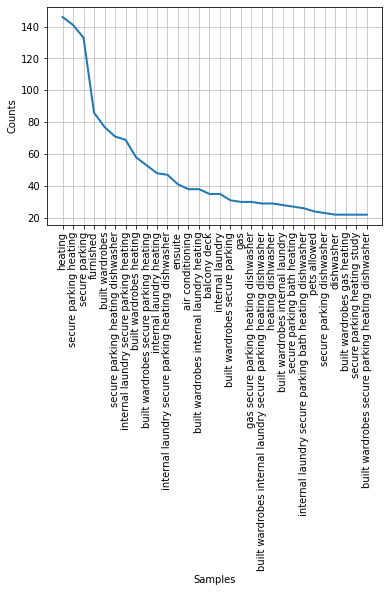

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [26]:
# Use nltk's FreqDist class to see the frequency of words in the text.
from nltk.probability import FreqDist
freq = FreqDist(df3['features'])
freq.plot(30)
# since we did not use this feature analysis in the subsequent process, we did not save this picture.

In [27]:
def classify_furnished(number):
    """
    function to sort numbers by their value
    Parameter: int
    Return a string 
    """
    if number >= 3:
        return "full_furnished"
    elif 2 <= number < 3:
        return "partial_furnished"
    else:
        return "no_furnished"

In [28]:
# Use the top 30 keywords from the plot
word_weights = {
    "heating": 0.01,
    "wardrobes": 0.01,
    "dishwasher": 0.01,
    "air" : 0.05,
    "conditioning" :0.05,
    "deck" : 2.0
}

In [29]:
def calculate_weight(text):
    """
    function to calculate the words weight
    Parameters: text = string
    Return weight after calculating 
    """

    # Convert to lower case and split words
    text = text.lower()
    words = word_tokenize(text)
    
    # If the text contains "furnish", return weight 3 directly.
    if "furnished" in words:
        return 3.0
    
    # Otherwise, calculate weights based on other words
    return sum(word_weights.get(word, 0) for word in words)

In [30]:
# Add new columns to show weights
df3['weight_furnished'] = df3['features'].apply(calculate_weight) 

# Use the apply method to apply the function and create a new column
df3['furnished'] = df3['weight_furnished'].apply(classify_furnished)

df4 = df3

/var/folders/1j/s266dkk51zd3br359qxtjkw00000gn/T/ipykernel_27095/1152699309.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['weight_furnished'] = df3['features'].apply(calculate_weight)
/var/folders/1j/s266dkk51zd3br359qxtjkw00000gn/T/ipykernel_27095/1152699309.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['furnished'] = df3['weight_furnished'].apply(classify_furnished)


In [31]:
x = df4['weight_furnished']
y = df4['price']

# Calculate Pearson's correlation coefficient and p-value
r, p_value = pearsonr(x, y)

print(f"Pearson's correlation coefficient: {r}")
print(f"P-value: {p_value}")

Pearson's correlation coefficient: 0.18642996134804082
P-value: 7.533856630435729e-85


In [32]:
def myAnova(data):
    """
    Function used to perform one-way ANOVA and print the p-value and conclusion
    Parameters: dataset
    Return: Null
    """
    column_names = data.columns.tolist()
    print("------------------------------------------")
    print(f"current processing anova for feature {column_names[1]} v.s. label {column_names[0]}")
    grouped = data.groupby(column_names[1])[column_names[0]].apply(list)
    
    # calculate p-value
    f_stat, p_value = stats.f_oneway(*grouped)

    # conclusion
    if(p_value <= 0.05):
        print(f"p-value is {p_value}, p-value <= 0.05, reject H0: the feature {column_names[1]} is not significant for {column_names[0]}")
        print(f"that means the feature {column_names[1]} for {column_names[0]} is significant\n")
    else:
        print(f"p-value is {p_value}, p-value > 0.05, reject H1: the feature {column_names[1]} is significant for {column_names[0]}")
        print(f"that means the feature {column_names[1]} for {column_names[0]} is not significant\n")

def myHeatMap(matrix, path):
    """
    Function used to plot a heatmap
    Parameters: matrix: a correlation matrix, path: path to store plots
    Return: Null
    """
    plt.figure(figsize=(14, 9))
    ax = sns.heatmap(matrix, annot= True, cmap='coolwarm', vmin=-1, vmax=1, annot_kws={'size': 20})

    # adjust size of each tick
    ax.set_xticklabels(ax.get_xticklabels(), fontsize = 20)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize = 20)

    # rotation on x label
    plt.xticks(rotation = 90)
    plt.title("Correlation between features", fontsize = 20)

    # save plots
    plt.savefig(path)
    plt.show()

def myHistogram(df, content, title, path):
    """
    Function used to plot a histogram
    Parameters: df: dataframe,
    content: name of y label
    title: title in plot 
    path: path to store plots
    Return: Null
    """
    df.plot(kind='bar', legend=False)
    plt.title(title)
    plt.ylabel(content)
    plt.xlabel("Type of property")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(path)
    plt.show()

def line_plotForType(df, path):
    """
    Function used to plot a line plot average price for each type of property in different number of bathrooms
    Parameters: matrix: dataset, path: path to store plots
    Return: Null
    """
    df.plot()
    plt.title('Average price for each type of property in different number of bathrooms')
    plt.xlabel('Number of bathrooms')
    plt.ylabel('Mean price')
    plt.legend(title='Type of property')

    # some configuration
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # x range
    plt.xticks(list(range(1, 10)))
    plt.savefig(path)
    plt.show()

In [36]:
# Get martix of correlation, select price...
numerical_features = ['price', 'bathrooms', 'bedrooms', 'parking']
numericalSet = df4[numerical_features]
correlation_numerical = numericalSet.corr()
myHeatMap(correlation_numerical)

TypeError: myHeatMap() missing 1 required positional argument: 'path'

In [37]:
df4

,price,bathrooms,bedrooms,parking,type,street,suburb,postcode,latitude,longitude,school,features,funished,school_count,weight_furnished,furnished
1,845.0,0,2,2,apartment unit flat,1101/83 Queens Road,MELBOURNE,3000.0,-37.854416,144.98044,Prahran High School1 km away7-11CoEdGovernment...,built wardrobes,no,3,0.01,no_furnished
2,800.0,0,2,0,apartment unit flat,3809/260 Spencer Street,MELBOURNE,3000.0,-37.814632,144.95262,Docklands Primary School1 km awayPrep-6CoEdGov...,balcony outdoor entertainment area swimming po...,no,4,0.13,no_furnished
5,750.0,0,1,1,apartment unit flat,11/6 Anthony Street,MELBOURNE,3000.0,-37.809494,144.95938,Carlton Gardens Primary School1.2 km awayPrep-...,furnished,yes,4,3.00,full_furnished
9,625.0,0,1,0,apartment unit flat,1903/639 Lonsdale Street,MELBOURNE,3000.0,-37.815010,144.95341,Docklands Primary School1.1 km awayPrep-6CoEdG...,gym intercom built wardrobes dishwasher split ...,yes,4,3.00,full_furnished
12,525.0,0,1,0,apartment unit flat,P22/394 Collins Street,MELBOURNE,3000.0,-37.816680,144.96104,Docklands Primary School1.8 km awayPrep-6CoEdG...,built wardrobes ducted heating furnished inter...,yes,4,3.00,full_furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13936,450.0,0,4,1,house,7A Scarborough Street,INVERLOCH,3996.0,-38.634270,145.72590,Inverloch Primary School0.4 km awayPrep-6CoEdG...,shed fully fenced,no,2,0.00,no_furnished
13937,435.0,0,3,0,house,3 Kennards Court,INVERLOCH,3996.0,-38.626730,145.72865,Inverloch Primary School0.5 km awayPrep-6CoEdG...,built wardrobes shed fully fenced,no,2,0.01,no_furnished
13938,420.0,0,2,0,house,28 Beilby Avenue,INVERLOCH,3996.0,-38.630350,145.73875,Inverloch Primary School0.9 km awayPrep-6CoEdG...,internal laundry fully fenced balcony deck,yes,2,2.00,partial_furnished
13939,460.0,0,2,1,apartment unit flat,1/18 Williams Street,INVERLOCH,3996.0,-38.632603,145.73026,Inverloch Primary School0.2 km awayPrep-6CoEdG...,secure parking furnished,yes,2,3.00,full_furnished
